<a href="https://colab.research.google.com/github/ms03831/image_captioning_tensorflow/blob/master/image_captioning_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#downloading and extracting data
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip 
!wget https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip 
!unzip Flickr8k_Dataset.zip
!unzip Flickr8k_text.zip


Streaming output truncated to the last 5000 lines.
  inflating: Flicker8k_Dataset/3429465163_fb8ac7ce7f.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429465163_fb8ac7ce7f.jpg  
  inflating: Flicker8k_Dataset/3429581486_4556471d1a.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429581486_4556471d1a.jpg  
  inflating: Flicker8k_Dataset/3429641260_2f035c1813.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429641260_2f035c1813.jpg  
  inflating: Flicker8k_Dataset/3429956016_3c7e3096c2.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3429956016_3c7e3096c2.jpg  
  inflating: Flicker8k_Dataset/3430100177_5864bf1e73.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430100177_5864bf1e73.jpg  
  inflating: Flicker8k_Dataset/3430287726_94a1825bbf.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430287726_94a1825bbf.jpg  
  inflating: Flicker8k_Dataset/3430526230_234b3550f6.jpg  
  inflating: __MACOSX/Flicker8k_Dataset/._3430526230_234b3550f6.jpg  
  inflating: Flicker8k_Dataset/3430607596_7e4f

In [2]:
#loading packages
import os
import numpy as np
import tensorflow as tf
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.layers import Dense, Dropout, Input, LSTM, Add, Lambda
from matplotlib import pyplot as plt

Using TensorFlow backend.


In [3]:
def load_pad_sequences(directory):
    #this function loads every caption in a dictionary corresponding it's and image
    # and appends start_token and end_token to start and end of it.
    image_caption = dict()
    lines = open(directory, 'r').readlines() #this gives list of lines
    for line in lines:
        tokens = line.strip().split('\t')
        # each line is image_id#n "tab" caption where n is the caption number
        image_id, image_desc = tokens[0], tokens[1] 
        image_id = image_id[:-2]  #getting rid of caption number from image id
        if image_id not in image_caption:
            image_caption[image_id] = []
        image_caption[image_id].append('start_token ' + image_desc.strip() + ' end_token')
    return image_caption 

dir = 'Flickr8k.token.txt'
image_caption = load_pad_sequences(dir)
#five captions of the first image
image_caption[list(image_caption.keys())[:1][0]]

['start_token A child in a pink dress is climbing up a set of stairs in an entry way . end_token',
 'start_token A girl going into a wooden building . end_token',
 'start_token A little girl climbing into a wooden playhouse . end_token',
 'start_token A little girl climbing the stairs to her playhouse . end_token',
 'start_token A little girl in a pink dress going into a wooden cabin . end_token']

In [4]:
#removing single letter words from captions
photo_ids = list(image_caption.keys())
print('before : ', image_caption[photo_ids[0]][0])
for image, caption in image_caption.items():
    for i in range(len(caption)):
        image_caption[image][i] = ' '.join([word for word in image_caption[image][i].split() if len(word) > 1])
print('after : ', image_caption[photo_ids[0]][0])

#list of captions
captions_list = []
for captions in image_caption.values():
     captions_list.extend([cap for cap in captions])


print(captions_list[0])
#the max length of caption(number of words) in our dataset
for i in captions_list:
    if len(i.split()) > 100:
        print(i)
max_length_desc = np.argmax([len(caption) for caption in captions_list])
max_length = captions_list[max_length_desc].split()
print(len(max_length), max_length)

before :  start_token A child in a pink dress is climbing up a set of stairs in an entry way . end_token
after :  start_token child in pink dress is climbing up set of stairs in an entry way end_token
start_token child in pink dress is climbing up set of stairs in an entry way end_token
34 ['start_token', 'An', 'African-American', 'man', 'wearing', 'green', 'sweatshirt', 'and', 'blue', 'vest', 'is', 'holding', 'up', 'dollar', 'bills', 'in', 'front', 'of', 'his', 'face', 'while', 'standing', 'on', 'busy', 'sidewalk', 'in', 'front', 'of', 'group', 'of', 'men', 'playing', 'instruments', 'end_token']


In [5]:
#complete vocabulary
string_caption = ' '.join(captions_list) #all captions as a string separated by just space
list_of_words =  [word for word in string_caption.split() if len(word) > 1] 
unique_words =  set(list_of_words)
print(len(unique_words))
vocabulary = dict()

for word in list_of_words:
    if word in vocabulary:
        vocabulary[word] += 1
    else:
        vocabulary[word] = 1
print(len(vocabulary))

9595
9595


In [6]:
reduced_vocabulary = dict()
for word, count in vocabulary.items():
    if count > 10 and word not in reduced_vocabulary:
        reduced_vocabulary[word] = count
print('reduced vocabulary %d ' % len(reduced_vocabulary))

reduced vocabulary 1888 


In [7]:
idx_word = {} #index to word
word_idx = {} #word to index  both useful for embedding 
idx = 0
for w in vocabulary:
    word_idx[w] = idx
    idx_word[idx] = w
    idx += 1

In [8]:
vgg_model = VGG16(weights = 'imagenet')
feature_extractor = keras.models.Sequential([
                        *vgg_model.layers[:-2]
                    ])
for i in feature_extractor.layers:
    i.trainable = False
feature_extractor.trainable = False

553467904/553467096 [==============================] - 8s 0us/step


NameError: ignored

In [ ]:
feature_extractor.summary()

In [9]:
#loads image and converts it into an array
def load_process(filenames):
    #lambda function that takes a file name and loads it into an array of defined target size
    load = lambda filename: img_to_array(load_img('Flicker8k_Dataset/'+filename, target_size=(224, 224, 3)))
    if len(filenames) > 1:
        loaded_images = np.array([load(image) for image in filenames])
    else:
        loaded_images = load(filenames)
    return loaded_images
        

In [10]:

def vgg_features(images_files):
    batch_size = 250
    
    image_features = []
    #processing in batch for faster processing
    for batch_start in range(0, len(images_files) - batch_size + 1, batch_size):
        images_to_process = load_process(images_files[batch_start:batch_start+batch_size])
		# reshape and preprocess data for vgg
        images_to_process = images_to_process.reshape(-1, 224, 224, 3)
        images_to_process = preprocess_input(images_to_process)
		# extracting features
        features250 = feature_extractor.predict(images_to_process, verbose=0)
        image_features.append(features250)
        print(",extracting ", batch_start, end=' ')
    image_features = np.concatenate(image_features, axis = 0)
    return image_features

def image_features(train, test):
    #train and test are directories contraining image names of images
    def load_file_names(dir):
        file = open(dir)
        images_files = list(set([line.strip() for line in file.readlines()]))
        return images_files
    train_files = load_file_names(train)
    test_files = load_file_names(test)
    train_features = vgg_features(train_files)
    test_features = vgg_features(test_files)
    return (train_files, train_features), (test_files, test_features) 

(train_files, train_features), (test_files, test_features) = image_features('Flickr_8k.trainImages.txt', 'Flickr_8k.devImages.txt')


NameError: ignored

In [ ]:
print('Extracted Train Features: ', train_features.shape)
print('Extracted Test Features: ', test_features.shape)

In [ ]:
from gensim.models import Word2Vec
from gensim import downloader as api
embedding = api.load('word2vec-google-news-300')

In [ ]:
embedding_n = 300
vocabulary_size = len(vocabulary)
#get 200-dim dense vector for each of the 9595 words in our vocabulary
embedding_matrix = np.zeros((vocabulary_size, embedding_n))
for word, i in word_idx.items():
    if word in embedding:        # Words not found in the embedding index will be all zeros
        vector = embedding[word]
        embedding_matrix[i] = vector
#emedding of start token
print(embedding_matrix[0])

In [12]:
inputs1 = Input(shape=(4096, ))
model1 = Dropout(0.3)(inputs1)
model1 = Dense(256, activation='relu')(model1)
model1 = Dropout(0.4)(model1)
model1 = Dense(512, activation='relu')(model1)
model1 = Dropout(0.5)(model1)
model1 = Dense(1024, activation='relu')(model1)


inputs2 = Input(shape=(10, 300)) #predicting based on previous 10 words only.
model2 = LSTM(1024)(inputs2)
model2 = Dense(1024, activation='relu')(model2)

model3 = Add()([model1, model2])
model3 = Dropout(0.3)(model3)
model3 = Dense(1024, activation = 'relu')(model3)
model3 = Dropout(0.3)(model3)
model3 = Dense(vocabulary_size, activation = 'softmax')(model3)

'''
model1 = tf.keras.models.Sequential([
                inputs1, 
                Dropout(0.3),
                Dense(256, activation='relu'),
                Dropout(0.4),
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(1024, activation='relu')
])

model2 = tf.keras.models.Sequential([
                inputs2, 
                LSTM(1024),
                Dense(1024, activation='relu')
])
print(model1.layers[-1])


model3 = tf.keras.models.Sequential([
                add_layer,
                Dense(512, activation='relu'),
                Dropout(0.5),
                Dense(1024, activation='relu'),
                Dense(vocabulary_size, activation = 'softmax')
])
'''

final_model = keras.models.Model([inputs1, inputs2], model3)
final_model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy')

NameError: ignored

In [ ]:
def pad_sequence(sequence, c_length, d_length): 
    #c_length is current length of sequence
    #d_length is desired length of sequence
    
    return [0]*(d_length - c_length) + sequence

def calculate_embedding(sequence):
    return np.array([embedding_matrix[idx] for idx in sequence])

In [11]:
# TRAIN LOOP
epochs = 5
batch_size = 256
n = 10
iteration = 0
for epoch in range(epochs):
    for batch_start in range(0, len(train_files) - batch_size + 1, batch_size):
        print("Epoch no {0}; batch of images no: {1}".format(epoch+1, iteration +1))
        iteration += 1
        batch = range(batch_start, batch_start+batch_size)
        input1, input2, Y = [], [], []
        for im in batch:
            image_id = train_files[im]
            image_feature_vector = train_features[im]
            for caption in image_caption[image_id]: #caption for each image
                
                for i in range(1, len(caption.split())):
                    input1.append(image_feature_vector)
                    y = word_idx[caption.split()[i]]
                    if i >= n:
                        start = max(0, n - i)
                        i2 = [word_idx[word] for word in caption.split()[start:i]]
                    else:
                        i2 = [word_idx[word] for word in caption.split()[:i]]
                        i2 = pad_sequence(i2, i, n) 
                    i2 = calculate_embedding(i2)
                    Y.append(y)
                    input2.append(i2)
        for i in range(0, len(input1)-batch_size+1, batch_size):
            lst = np.array([input2[l][:10] for l in range(i,i+batch_size)])
            #print(lst.shape)
            inp1, inp2, Y_ = input1[i:i+batch_size], lst, Y[i:i+batch_size]
            inp1 = np.array(inp1).reshape(-1, 4096)
            inp2 = np.array(inp2).reshape(-1, n, 300)
            Y_ = np.array(Y_)
            #print(inp1.shape, inp2.shape, Y_.shape)
            loss = final_model.train_on_batch([inp1, inp2], Y_)

NameError: ignored

# Random images with caption:

>*** The model hasn't seen the dev images, so we can use those to generate captions and see how well it's doing**

['2444741900_5cb3ef3e1d.jpg', '1346051107_9cdc14e070.jpg', '3159641529_c2c74f3eaf.jpg', '427936315_0b8f7b8d23.jpg', '397286183_745abbf40d.jpg']


ValueError: ignored

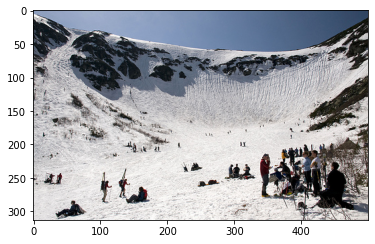

In [118]:
def vgg_predict_one(file): 
    image = img_to_array(load_img(file), target_size = (224, 224, 3))
    image = preprocess_input(image).reshape(1,224,224,3)
    return feature_extractor.predict(image)

rand_image_idx = np.random.choice(len(test_files), 5) 
rand_image_files = [test_files[i] for i in rand_image_idx]
rand_image_features = [test_features[i] for i in rand_image_idx]
rand_images = load_process(rand_image_files)
n = 10
dir = "Flicker8k_Dataset/"
for i in range(5):
    description = ''
    plt.imshow(img_to_array(load_img(dir+rand_image_files[i])).astype(int))
    
#    sequence_embedding = np.zeros(shape = (1, n, 300))
    count = 1 #length of generated caption
    caption = 'start_token'
    while True and count <= len(max_length):
        if count >= n:
            start = max(0, n - count)
            i2 = [word_idx[word] for word in caption.split()[start:count]]
        else:
            i2 = [word_idx[word] for word in caption.split()[:count]]
            i2 = pad_sequence(i2, count, n) 
        i2 = calculate_embedding(i2).reshape(1, n, 300)
        idx = final_model.predict([rand_image_features[i], i2])[0].argmax()
        if idx_word[idx] == 'end_token':
            break
        caption += idx_word[idx] + ' '
        count += 1
    plt.title(caption[1:-1])
    plt.show()
